Found 17625 files belonging to 5 classes.
Found 2820 files belonging to 5 classes.
Epoch 1/5
551/551 ━━━━━━━━━━━━━━━━━━━━ 61s 92ms/step - accuracy: 0.2378 - loss: 1.5999 - val_accuracy: 0.2915 - val_loss: 1.5375
Epoch 2/5
551/551 ━━━━━━━━━━━━━━━━━━━━ 69s 84ms/step - accuracy: 0.2969 - loss: 1.5367 - val_accuracy: 0.3330 - val_loss: 1.4924
Epoch 3/5
551/551 ━━━━━━━━━━━━━━━━━━━━ 83s 85ms/step - accuracy: 0.3109 - loss: 1.5200 - val_accuracy: 0.3096 - val_loss: 1.5129
Epoch 4/5
551/551 ━━━━━━━━━━━━━━━━━━━━ 77s 77ms/step - accuracy: 0.3272 - loss: 1.5053 - val_accuracy: 0.3355 - val_loss: 1.4801
Epoch 5/5
551/551 ━━━━━━━━━━━━━━━━━━━━ 82s 77ms/step - accuracy: 0.3380 - loss: 1.4945 - val_accuracy: 0.3440 - val_loss: 1.4856


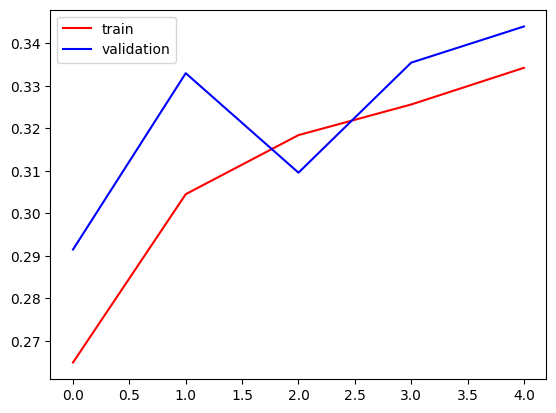

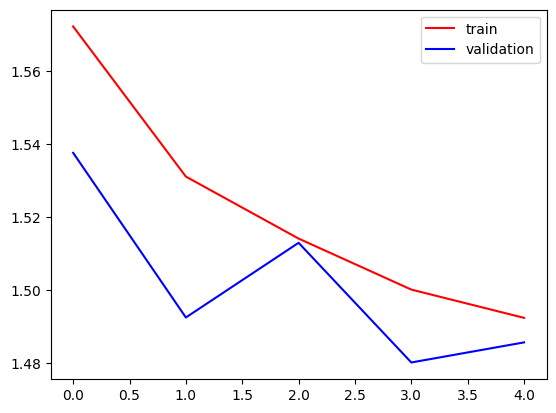

In [ ]:
import zipfile
import os
import cv2
import numpy as np
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16

# Unzip the data
zip_ref = zipfile.ZipFile('/content/Aug_Data.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

zip_ref = zipfile.ZipFile('/content/Training.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

# Load VGG16 without fully connected layers
conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)  # Ensure input shape matches the data
)

# Freeze the convolutional base layers
conv_base.trainable = False

# Build the model
model = Sequential()
model.add(conv_base)
model.add(GlobalAveragePooling2D())  # GAP reduces shape issues vs. Flatten
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))  # 5 output classes

# Model summary
# model.summary()

# Data generators
train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/Aug_Data',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(150, 150)  # Resizes images to 150x150
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory='/content/Training',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(150, 150)
)

# Normalize the datasets
def process(image, label):
    image = keras.layers.Rescaling(1./255)(image)  # Normalize images to [0, 1]
    return image, label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_ds, epochs=5, validation_data=validation_ds)

# Plot accuracy and loss curves
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='validation')
plt.legend()
plt.show()

plt.plot(history.history['loss'], color='red', label='train')
plt.plot(history.history['val_loss'], color='blue', label='validation')
plt.legend()
plt.show()


# To Test Dinamic Code

In [ ]:
import os
import zipfile
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# 1. Extract zip files (Augmented Data and Training Data)
zip_ref = zipfile.ZipFile('/content/Aug_Data.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

zip_test = zipfile.ZipFile('/content/Training.zip', 'r')
zip_test.extractall('/content')
zip_test.close()

# 2. Load VGG16 Pre-trained Model
conv_base = VGG16(
    weights='imagenet',         # Use pre-trained weights from ImageNet
    include_top=False,          # Don't include the fully connected layers
    input_shape=(150, 150, 3)   # Input image shape
)

# 3. Freezing most of the VGG16 layers, but unfreezing some for fine-tuning
conv_base.trainable = True  # Unfreeze the top layers for fine-tuning
for layer in conv_base.layers[:-4]:  # Freeze all layers except the last 4 convolutional blocks
    layer.trainable = False

# 4. Build the model with additional custom layers
model = Sequential([
    conv_base,
    GlobalAveragePooling2D(),    # More robust than Flatten
    Dense(256, activation='relu'),  # Fully connected layer
    Dropout(0.5),                # Dropout to prevent overfitting
    Dense(5, activation='softmax')  # 5 output classes for diabetic retinopathy classification
])

model.load_weights('/content/best_model.keras')

# 5. Model Summary
# model.summary()

ValueError: A total of 2 objects could not be loaded. Example error message for object <Dense name=dense_10, built=False>:

Layer 'dense_10' was never built and thus it doesn't have any variables. However the weights file lists 2 variables for this layer.
In most cases, this error indicates that either:

1. The layer is owned by a parent layer that implements a `build()` method, but calling the parent's `build()` method did NOT create the state of the child layer 'dense_10'. A `build()` method must create ALL state for the layer, including the state of any children layers.

2. You need to implement the `def build_from_config(self, config)` method on layer 'dense_10', to specify how to rebuild it during loading. In this case, you might also want to implement the method that generates the build config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the layer (i.e. its variables) upon deserialization.

List of objects that could not be loaded:
[<Dense name=dense_10, built=False>, <Dense name=dense_11, built=False>]

In [ ]:
# 6. Data Augmentation to prevent overfitting and improve generalization
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

# 7. Generators for train and validation datasets
train_ds = train_datagen.flow_from_directory(
    directory='/content/Aug_Data',
    target_size=(150, 150),
    batch_size=32,
    class_mode='sparse'  # Use sparse categorical for integer labels
)

validation_ds = validation_datagen.flow_from_directory(
    directory='/content/Training',
    target_size=(150, 150),
    batch_size=32,
    class_mode='sparse'
)

# # 8. Add EarlyStopping and ModelCheckpoint callbacks to prevent overfitting
# early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# checkpoint = ModelCheckpoint('/content/best_model.h5', monitor='val_accuracy', save_best_only=True)

# # 9. Compile the model with a lower learning rate for fine-tuning
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Fine-tuning requires a low learning rate
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )

# # 10. Train the model with early stopping
# history = model.fit(
#     train_ds,
#     epochs=20,  # Increase epochs for better learning
#     validation_data=validation_ds,
#     callbacks=[early_stop, checkpoint]
# )

# # 11. Plot Training/Validation Accuracy and Loss
# plt.plot(history.history['accuracy'], color='red', label='train accuracy')
# plt.plot(history.history['val_accuracy'], color='blue', label='validation accuracy')
# plt.legend()
# plt.title('Training and Validation Accuracy')
# plt.show()

# plt.plot(history.history['loss'], color='red', label='train loss')
# plt.plot(history.history['val_loss'], color='blue', label='validation loss')
# plt.legend()
# plt.title('Training and Validation Loss')
# plt.show()

# # 12. Loading and using the best saved model for prediction
# best_model = keras.models.load_model('/content/best_model.h5')


# 8. Add EarlyStopping and ModelCheckpoint callbacks to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('/content/best_model.keras', monitor='val_accuracy', save_best_only=True)

# 9. Compile the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Fine-tuning requires a low learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 10. Train the model with early stopping
history = model.fit(
    train_ds,
    epochs=20,  # Increase epochs for better learning
    validation_data=validation_ds,
    callbacks=[early_stop, checkpoint]
)


Found 17625 images belonging to 5 classes.
Found 2820 images belonging to 5 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


551/551 ━━━━━━━━━━━━━━━━━━━━ 130s 226ms/step - accuracy: 0.2091 - loss: 1.6891 - val_accuracy: 0.3145 - val_loss: 1.5331
Epoch 2/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 135s 218ms/step - accuracy: 0.2735 - loss: 1.5651 - val_accuracy: 0.3227 - val_loss: 1.5010
Epoch 3/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 121s 217ms/step - accuracy: 0.3082 - loss: 1.5270 - val_accuracy: 0.3223 - val_loss: 1.4920
Epoch 4/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 124s 222ms/step - accuracy: 0.3137 - loss: 1.5128 - val_accuracy: 0.3401 - val_loss: 1.4783
Epoch 5/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 138s 215ms/step - accuracy: 0.3265 - loss: 1.4951 - val_accuracy: 0.3585 - val_loss: 1.4576
Epoch 6/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 119s 215ms/step - accuracy: 0.3429 - loss: 1.4681 - val_accuracy: 0.3528 - val_loss: 1.4432
Epoch 7/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 144s 218ms/step - accuracy: 0.3548 - loss: 1.4594 - val_accuracy: 0.3752 - val_loss: 1.4400
Epoch 8/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 118s 212ms/step - accuracy: 0.3553 - loss: 1.44

ValueError: Layer "dense_8" expects 1 input(s), but it received 2 input tensors. Inputs received: [<KerasTensor shape=(None, 4, 4, 512), dtype=float32, sparse=False, name=keras_tensor_147>, <KerasTensor shape=(None, 4, 4, 512), dtype=float32, sparse=False, name=keras_tensor_148>]

In [ ]:
# 12. Loading and using the best saved model for prediction
best_model = keras.models.load_model('/content/best_model.keras')

In [ ]:
# 13. Function to predict diabetic retinopathy from a new image
def predict_new_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (150, 150))  # Resize image to match model input size
    img = np.expand_dims(img, axis=0)  # Expand dimensions to fit model input shape
    img = img / 255.0  # Normalize image

    prediction = best_model.predict(img)
    predicted_class = np.argmax(prediction, axis=1)[0]  # Get predicted class
    confidence = np.max(prediction) * 100  # Confidence score

    class_names = ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
    print(f"Predicted: {class_names[predicted_class]} with {confidence:.2f}% confidence")

image_path = '/content/image_864_31.jpg'
predict_new_image(image_path)
# Example: To predict a new image (replace 'new_image_path' with the actual image path)
# predict_new_image('/content/new_fundus_image.jpg')

# Updated Model

In [ ]:
import os
import zipfile
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [ ]:
# 1. Extract zip files (Augmented Data and Training Data)
zip_ref = zipfile.ZipFile('/content/Aug_Data.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

zip_test = zipfile.ZipFile('/content/Training.zip', 'r')
zip_test.extractall('/content')
zip_test.close()

In [ ]:
# 2. Load VGG16 Pre-trained Model
conv_base = VGG16(
    weights='imagenet',         # Use pre-trained weights from ImageNet
    include_top=False,          # Don't include the fully connected layers
    input_shape=(150, 150, 3)   # Input image shape
)


In [ ]:
# 3. Freeze the base model layers except for fine-tuning
conv_base.trainable = True  # Unfreeze the top layers for fine-tuning
for layer in conv_base.layers[:-4]:  # Freeze all layers except the last 4 convolutional blocks
    layer.trainable = False

# 4. Build the model with additional custom layers
model = Sequential([
    conv_base,
    GlobalAveragePooling2D(),    # More robust than Flatten
    Dense(256, activation='relu'),  # Fully connected layer
    Dropout(0.5),                # Dropout to prevent overfitting
    Dense(5, activation='softmax')  # 5 output classes for diabetic retinopathy classification
])

In [ ]:
# 5. Data Augmentation to prevent overfitting and improve generalization
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)


In [ ]:
# 6. Generators for train and validation datasets
train_ds = train_datagen.flow_from_directory(
    directory='/content/Aug_Data',
    target_size=(150, 150),
    batch_size=32,
    class_mode='sparse'  # Use sparse categorical for integer labels
)

validation_ds = validation_datagen.flow_from_directory(
    directory='/content/Training',
    target_size=(150, 150),
    batch_size=32,
    class_mode='sparse'
)

Found 17625 images belonging to 5 classes.
Found 2820 images belonging to 5 classes.


In [ ]:
# 7. Add EarlyStopping and ModelCheckpoint callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('/content/best_model.keras', monitor='val_accuracy', save_best_only=True)

# 8. Compile the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Fine-tuning requires a low learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# 9. Train the model with early stopping
history = model.fit(
    train_ds,
    epochs=10,  # Increase epochs for better learning
    validation_data=validation_ds,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


551/551 ━━━━━━━━━━━━━━━━━━━━ 136s 239ms/step - accuracy: 0.2083 - loss: 1.7021 - val_accuracy: 0.2890 - val_loss: 1.5602
Epoch 2/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 133s 226ms/step - accuracy: 0.2699 - loss: 1.5705 - val_accuracy: 0.3188 - val_loss: 1.5283
Epoch 3/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 127s 228ms/step - accuracy: 0.2924 - loss: 1.5409 - val_accuracy: 0.3305 - val_loss: 1.5160
Epoch 4/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 135s 215ms/step - accuracy: 0.3148 - loss: 1.5165 - val_accuracy: 0.3230 - val_loss: 1.5115
Epoch 5/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 152s 232ms/step - accuracy: 0.3254 - loss: 1.5012 - val_accuracy: 0.3426 - val_loss: 1.4843
Epoch 6/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 126s 226ms/step - accuracy: 0.3362 - loss: 1.4858 - val_accuracy: 0.3553 - val_loss: 1.4703
Epoch 7/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 136s 214ms/step - accuracy: 0.3480 - loss: 1.4648 - val_accuracy: 0.3500 - val_loss: 1.4877
Epoch 8/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 124s 223ms/step - accuracy: 0.3560 - loss: 1.45

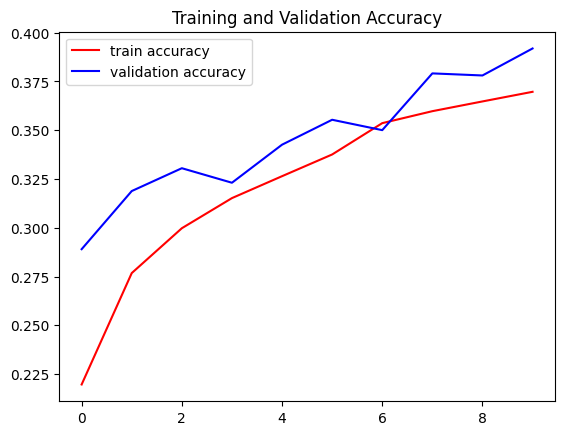

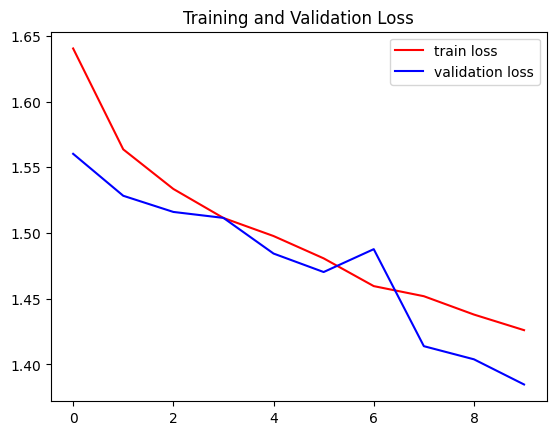

In [ ]:
# 10. Plot Training/Validation Accuracy and Loss
plt.plot(history.history['accuracy'], color='red', label='train accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label='validation accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(history.history['loss'], color='red', label='train loss')
plt.plot(history.history['val_loss'], color='blue', label='validation loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
# 11. Loading and using the best saved model for prediction
best_model = keras.models.load_model('/content/best_model.keras')

ValueError: Layer "dense_12" expects 1 input(s), but it received 2 input tensors. Inputs received: [<KerasTensor shape=(None, 4, 4, 512), dtype=float32, sparse=False, name=keras_tensor_234>, <KerasTensor shape=(None, 4, 4, 512), dtype=float32, sparse=False, name=keras_tensor_235>]

In [ ]:
# 12. Function to predict diabetic retinopathy from a new image
def predict_new_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (150, 150))  # Resize image to match model input size
    img = np.expand_dims(img, axis=0)  # Expand dimensions to fit model input shape
    img = img / 255.0  # Normalize image

    prediction = best_model.predict(img)
    predicted_class = np.argmax(prediction, axis=1)[0]  # Get predicted class
    confidence = np.max(prediction) * 100  # Confidence score

    class_names = ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
    print(f"Predicted: {class_names[predicted_class]} with {confidence:.2f}% confidence")

# 13. Example: To predict a new image (replace with actual image path)
predict_new_image('/content/image_733_9.jpg')

NameError: name 'cv2' is not defined